## ECE 285 - Final Project
## Training a neural network to predict image category using functional magnetic resonance imaging (fMRI) signals.
### Instructor: Xiaolong WANG
*****************************************************************************************************************
Shayne Wang, A15776202, June 2023
******************************************************************************************************************

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
import random

#from torch.utils.data import Dataset
#import torchvision
#import torchvision.transforms as transforms
#import torchvision.transforms as T

# Option to use GPU
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

Tensor = torch.cuda.FloatTensor if USE_GPU else torch.FloatTensor
np.random.seed(0)

using device: cuda


In [41]:
###################################################################################
#  Section 1: DATA IMPORT
#  We import the dataset in .csv format and convert each into a data frame
#  The dataset has been divided into 4 files. Note that each file has different
#  number of columns.
#  Generate X and Y in numpy from data frame
###################################################################################

def importData(file_name):
    """
    Convert data in a csv file to numpy

    Inputs:
    - one of the csv file name for dataset

    Returns:
    - X: 2-D tensor, float32
    - Y: 1-D tensor, int
    - class_dict: a dictionary for the classes in this dataset
    """
    # read in csv file and convert to data frame
    pd_fMRI = pd.read_csv(file_name)

    # display the 5 lines of the data frame
    print('*'*100)
    print(pd_fMRI.head())

    # generate X and Y in numpy
    X = pd_fMRI.values[:,2:-1].astype(float)
    Y = pd_fMRI.values[:,-1]
    print('shape of data: ', X.shape, Y.shape)

    # filter out the name of categories
    Y_class = set(Y.tolist())
    # create a dictionary for category vs index
    class_dict = dict(zip(Y_class,range(len(Y_class))))
    print('class in this dataset:\n',class_dict)
    print('*'*100)
    # convert category Y into integer since PyTorch doesn't have dtype for string
    Y = np.array([class_dict.get(a_class) for a_class in Y.tolist()])
    return Tensor(X),Tensor(Y),class_dict

# read out 4 csv files
X_data_1, Y_data_1, class_dict_1 = importData('df_merged_subject1.csv')
X_data_2, Y_data_2, class_dict_2 = importData('df_merged_subject2.csv')
X_data_3, Y_data_3, class_dict_3 = importData('df_merged_subject3.csv')
X_data_4, Y_data_4, class_dict_4 = importData('df_merged_subject4.csv')

****************************************************************************************************
   subject                         image_id  LHEarlyVis#0  LHEarlyVis#1  \
0        1             n01930112_19568.JPEG      0.167271      1.173377   
1        1             n03733281_29214.JPEG      1.258984      0.744704   
2        1              n07695742_5848.JPEG      0.279666     -0.164892   
3        1  COCO_train2014_000000420713.jpg      0.473376     -0.299339   
4        1  COCO_train2014_000000488558.jpg      0.224416      1.852141   

   LHEarlyVis#2  LHEarlyVis#3  LHEarlyVis#4  LHEarlyVis#5  LHEarlyVis#6  \
0     -0.482830      0.561836      0.487629     -1.366299      0.526726   
1      0.264117     -0.199035      0.221795     -1.114712      0.549931   
2     -0.550474      0.587374      0.319142     -0.022280      1.146169   
3      0.365422      0.443424      0.986940      0.916352      0.656573   
4      1.087473     -0.393302      0.129446      0.858346     -0.352569  

In [42]:
###################################################################################
#  Section 2: DATA PREPROCESSING AND SPLIT
#  Preprocess the data in this section
#  Split the dataset into training:validation:test = 80%:10%:10%.
###################################################################################

def createLoader(X_data,Y_data,batch_size):
    """
    Generate 3 dataloader for training, val and test sets.

    Inputs:
    - X_data,Y_data: tensor, dataset ready for split
    - batch_size: int, number of batch size fed to the model at a time

    Returns:
    - 3 loader respectively for training, val and test sets
    """
    # Encapsulate as a dataset (X,Y) ready to split
    dataset = TensorDataset(Tensor(X_data), Tensor(Y_data))
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader,valid_dataloader,test_dataloader


In [43]:
###################################################################################
#  Section 3: A TRAINING LOOP AND CHECK ACCURACY FUNCTIONS
#  Used to train any SELF-DEFINED MODEL and return accuracy on training set
#  check_accuracy_part34 return accuracy of dataloadfer.
###################################################################################
# use dataloader to feed the model
def train_part34(model, train_dataloader, valid_dataloader, optimizer, epochs=1):
    """
    A training loop

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - train_dataloader, valid_dataloader: the data loaders for training and val sets.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: The accuracy of the model
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_dataloader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(valid_dataloader, model, isTestSet=False)
                print()
    return check_accuracy_part34(valid_dataloader, model, isTestSet=False)


def check_accuracy_part34(loader, model, isTestSet=True):

    if isTestSet:
        print('Checking accuracy on test set')
    else:
        print('Checking accuracy on validation set')

    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [44]:
# Define a Flatten layer. Use it before FCL if the input tensor is NOT 2-D.
def flatten(x):
    N = x.shape[0] # read in N, C, H, W, or N,C,W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [45]:
###################################################################################
#  Section 4: Model 1
#  Define a 2-layer MLP.
#  This is a baseline
###################################################################################

learning_rate = 1e-3
hidden_layer_size = 256
epochs = 100
batch_size = 512

# Constant to control how frequently we print train loss
print_every = 100

def testModel1(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model

    Inputs:
    - Tensors and the dictionary for a csv file

    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    input_dim = X_data.shape[1]
    num_class = len(class_dict_1)

    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)

    model1 = None
    # define and modify the architecture
    model1 = nn.Sequential(
        #nn.BatchNorm1d(input_dim),
        nn.Linear(input_dim, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, num_class),
        nn.ReLU()
    )

    optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

    train_part34(model1, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model1)
    print('*'*60)

#test Model1 upon 4 csv files
print('*'*60)
testModel1(X_data_1, Y_data_1, class_dict_1)
testModel1(X_data_2, Y_data_2, class_dict_2)
testModel1(X_data_3, Y_data_3, class_dict_3)
testModel1(X_data_4, Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 290 / 502 correct (57.77)
Checking accuracy on test set
Got 298 / 504 correct (59.13)
************************************************************
Checking accuracy on validation set
Got 262 / 502 correct (52.19)
Checking accuracy on test set
Got 267 / 504 correct (52.98)
************************************************************
Checking accuracy on validation set
Got 259 / 502 correct (51.59)
Checking accuracy on test set
Got 283 / 504 correct (56.15)
************************************************************
Checking accuracy on validation set
Got 153 / 300 correct (51.00)
Checking accuracy on test set
Got 169 / 302 correct (55.96)
************************************************************


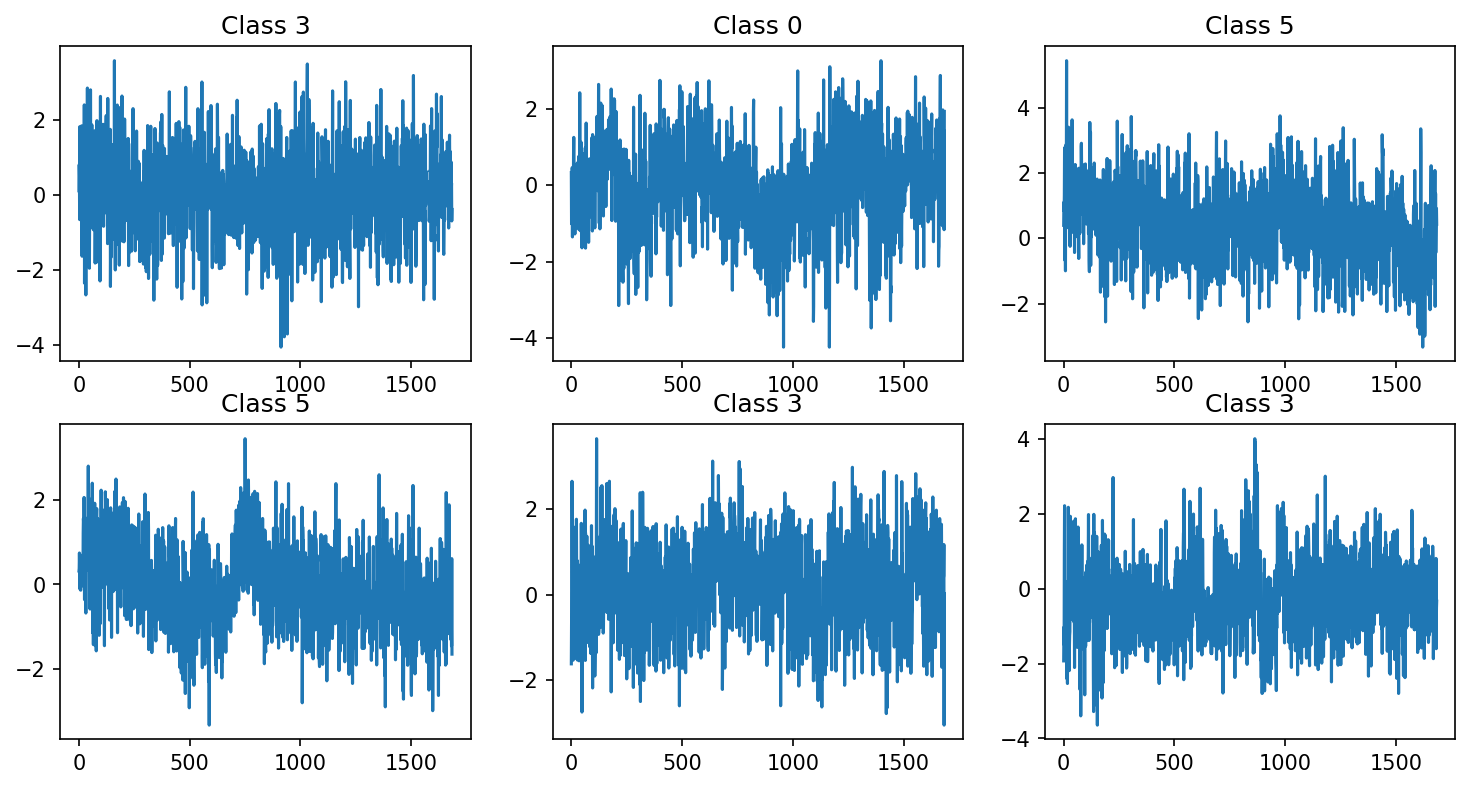

In [46]:
###################################################################################
#  Section 5a: Visualize 6 Records form 1st csv file as Sequences
###################################################################################

from matplotlib import pyplot as plt

x_num = X_data_1.shape[1]
index = random.sample(range(x_num),6)

fig = plt.figure(figsize=(12,6),dpi=150)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(range(x_num),X_data_1.cpu()[index[i]])
    plt.title('Class '+str(int(Y_data_1[i])))

plt.show()

In [47]:
###################################################################################
#  Section 5b: Model 2
#  Define a CNN with 2 convolutional layers + 2 FCLs.
###################################################################################

learning_rate = 1e-3
epochs = 20
batch_size = 64

# Constant to control how frequently we print train loss
print_every = 100

def testModel2(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model

    Inputs:
    - Tensors and the dictionary for a csv file

    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    num_col = X_data.shape[-1]
    num_class = len(class_dict_1)
    kernel_size = 5
    num_pool_size = 2
    hidden_dim =256
    num_conv1 = num_col - kernel_size + 1
    num_pool1 = num_conv1//num_pool_size
    num_conv2 = num_pool1 - kernel_size + 1
    num_pool2 = num_conv2//num_pool_size

    # Normalized the input array to N(0,1)
    data_mean =np.mean(X_data)
    data_std = np.std(X_data)
    X_data = (X_data-data_mean)/data_std

    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)

    model2 = None
    # define and modify the architecture
    model2 = nn.Sequential(
        nn.Conv1d(1, 10, kernel_size=kernel_size), #conv1: 1685 =>1661
        nn.ReLU(),
        nn.BatchNorm1d(10),
        nn.AvgPool1d(num_pool_size), # =>415 # pool1

        nn.Conv1d(10, 25, kernel_size=kernel_size), # conv2: 415 => 391
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.AvgPool1d(num_pool_size), #pool2  => 97
        nn.Dropout(0.5),

        Flatten(),  # N,1,W => N,W
        nn.Linear(num_pool2*25,hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim,num_class),
        nn.ReLU()
    )

    optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

    train_part34(model2, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model2)
    print('*'*60)

#test Model2 upon 4 csv files
print('*'*60)
# Conv1d requires 3-D input tensor.
testModel2(np.expand_dims(X_data_1.cpu(),1), Y_data_1, class_dict_1)
testModel2(np.expand_dims(X_data_2.cpu(),1), Y_data_2, class_dict_2)
testModel2(np.expand_dims(X_data_3.cpu(),1), Y_data_3, class_dict_3)
testModel2(np.expand_dims(X_data_4.cpu(),1), Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 266 / 502 correct (52.99)
Checking accuracy on test set
Got 289 / 504 correct (57.34)
************************************************************
Checking accuracy on validation set
Got 250 / 502 correct (49.80)
Checking accuracy on test set
Got 231 / 504 correct (45.83)
************************************************************
Checking accuracy on validation set
Got 259 / 502 correct (51.59)
Checking accuracy on test set
Got 257 / 504 correct (50.99)
************************************************************
Checking accuracy on validation set
Got 139 / 300 correct (46.33)
Checking accuracy on test set
Got 158 / 302 correct (52.32)
************************************************************


In [48]:
###################################################################################
#  RE-MODIFIED 1D CNN MODEL
#  Section 5c: Model 2b
#  we modify it to 4 convolutional layers + 3 FCLs.
###################################################################################

learning_rate = 1e-2
epochs = 20
batch_size = 64

# Constant to control how frequently we print train loss
print_every = 100

def testModel2b(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model

    Inputs:
    - Tensors and the dictionary for a csv file

    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    num_col = X_data.shape[-1]
    num_class = len(class_dict_1)
    kernel_size = 3
    num_pool_size = 2

    num_conv1 = (num_col - kernel_size)//2 + 1 # set stride=2
    num_pool1 = num_conv1//num_pool_size
    num_conv2 = (num_pool1 - kernel_size)//2 + 1
    num_pool2 = num_conv2//num_pool_size
    num_conv3 = (num_pool2 - kernel_size)//2 + 1
    num_pool3 = num_conv3//num_pool_size
    num_conv4 = (num_pool3 - kernel_size)//2 + 1
    num_pool4 = num_conv4//num_pool_size  # output from last conv layer

    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)

    model2b = None
    # define and modify the architecture
    model2b = nn.Sequential(
        nn.Conv1d(1, 16, kernel_size=kernel_size, stride=2), #conv1: 1685 => 841
        nn.ReLU(),
        nn.MaxPool1d(num_pool_size), # =>420 # pool1

        nn.Conv1d(16, 32, kernel_size=kernel_size, stride=2), #conv1: 420 => 210
        nn.ReLU(),
        nn.MaxPool1d(num_pool_size),  # pool2: 210 => 105

        nn.Conv1d(32, 64, kernel_size=kernel_size, stride=2), #conv1: 105 => 52
        nn.ReLU(),
        nn.MaxPool1d(num_pool_size),  # pool2: 52 => 26

        nn.Conv1d(64, 128, kernel_size=kernel_size, stride=2), #conv1: 26 => 12
        nn.ReLU(),
        nn.MaxPool1d(num_pool_size),  # pool2: 12 => 6

        Flatten(),  # N,1,W => N,W
        nn.Linear(num_pool4*128,256), # 128 filters
        nn.ReLU(),
        nn.Linear(256,50),
        nn.ReLU(),
        nn.Linear(50,num_class),
        nn.ReLU(),
    )

    optimizer = torch.optim.SGD(model2b.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

    train_part34(model2b, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model2b)
    print('*'*60)

#test Model2 upon 4 csv files
print('*'*60)
# Conv1d requires 3-D input tensor.
testModel2b(np.expand_dims(X_data_1.cpu(),1), Y_data_1, class_dict_1)
testModel2b(np.expand_dims(X_data_2.cpu(),1), Y_data_2, class_dict_2)
testModel2b(np.expand_dims(X_data_3.cpu(),1), Y_data_3, class_dict_3)
testModel2b(np.expand_dims(X_data_4.cpu(),1), Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 276 / 502 correct (54.98)
Checking accuracy on test set
Got 269 / 504 correct (53.37)
************************************************************
Checking accuracy on validation set
Got 240 / 502 correct (47.81)
Checking accuracy on test set
Got 249 / 504 correct (49.40)
************************************************************
Checking accuracy on validation set
Got 260 / 502 correct (51.79)
Checking accuracy on test set
Got 267 / 504 correct (52.98)
************************************************************
Checking accuracy on validation set
Got 148 / 300 correct (49.33)
Checking accuracy on test set
Got 140 / 302 correct (46.36)
************************************************************


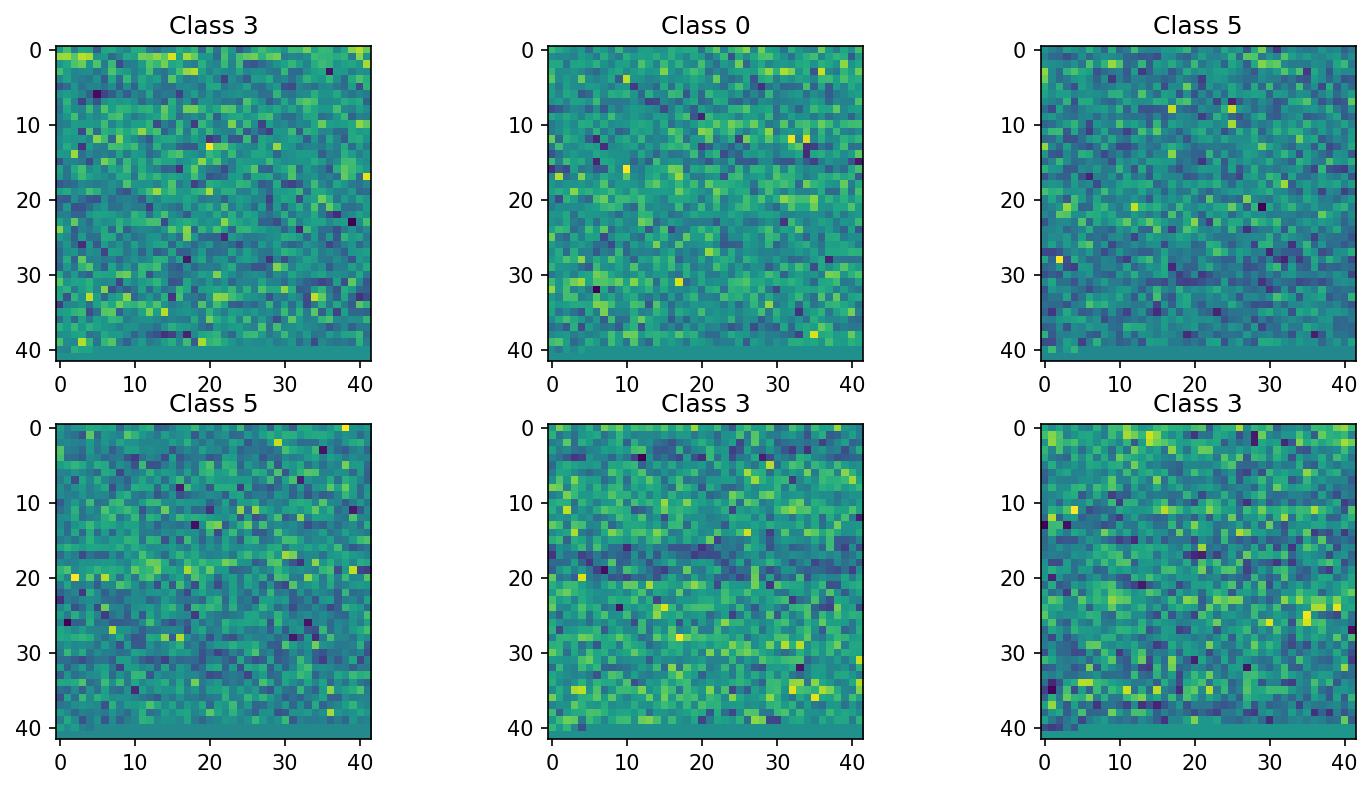

In [53]:
###################################################################################
#  Section 6a: Visualize 6 Records form 1st csv file as Feature Map
###################################################################################

x_num,w = X_data_1.shape

# We consider each record (a vector) as a flattened feature map
# so we perform Min Max Scaling to [0,1]
def minMaxScaling(X):
    X = X.clone()
    minVal, maxVal = torch.min(X), torch.max(X)
    return (X-minVal)/(maxVal-minVal)

# we reshape 1st-3rd dataset into size of 42*42.
X_data_11 = minMaxScaling(X_data_1)
X_data_11 = np.c_[X_data_1.cpu(),np.zeros((x_num,42*42-w))]
X_data_11 = X_data_11.reshape(x_num,1,42,42)

index = random.sample(range(x_num),6)

fig = plt.figure(figsize=(12,6),dpi=150)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_data_11[i,:,:,:].reshape(42,42))
    plt.title('Class '+str(int(Y_data_1[i])))

plt.show()

In [59]:
###################################################################################
#  Section 6b: Model 3 - 2D CNN model, a trained VGG-16
#  also 4 convolutional layers + 3 FCLs.
###################################################################################

learning_rate = 1e-3
epochs = 20
batch_size = 64

# Constant to control how frequently we print train loss
print_every = 100

vgg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

class VGG(nn.Module):
    def __init__(self, vgg):
        super(VGG, self).__init__()
        self.features = self._make_layers(vgg)
        self.dense = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(4096, 7)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        out = self.classifier(out)
        return out

    def _make_layers(self, vgg):
        layers = []
        in_channels = 3
        for x in vgg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

def testModel3(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model

    Inputs:
    - Tensors and the dictionary for a csv file

    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    num_class = len(class_dict_1)

    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)

    model3 = VGG(vgg)

    #optimizer = torch.optim.AdamW(model3.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-6)

    optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1)

    #optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

    train_part34(model3, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model3)
    print('*'*60)

#test Model3-VGG upon 4 csv files
def dataForVGG(X,size):
    """
    Prepare data for VGG model
    MinMax Scaling and convert a vector into a size x size feature map
    """
    X = X.clone()
    x_num,w = X.shape
    X = minMaxScaling(X)
    X = np.c_[X,np.zeros((x_num,size*size-w))] # pad 0
    return X.reshape(x_num,1,size,size).repeat(3,axis=1) # reshape to a square and turn to RGB 3 channels

print('*'*60)
# Conv1d requires 3-D input tensor.
testModel3(dataForVGG(X_data_1.cpu(),42), Y_data_1, class_dict_1)
testModel3(dataForVGG(X_data_2.cpu(),42), Y_data_2, class_dict_1)
testModel3(dataForVGG(X_data_3.cpu(),42), Y_data_3, class_dict_1)
# the 4th dataset has 2787 columns. we reshape it into size of 54*54.
testModel3(dataForVGG(X_data_4.cpu(),54), Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 257 / 502 correct (51.20)
Checking accuracy on test set
Got 266 / 504 correct (52.78)
************************************************************
Checking accuracy on validation set
Got 220 / 502 correct (43.82)
Checking accuracy on test set
Got 221 / 504 correct (43.85)
************************************************************
Checking accuracy on validation set
Got 230 / 502 correct (45.82)
Checking accuracy on test set
Got 232 / 504 correct (46.03)
************************************************************
Checking accuracy on validation set
Got 155 / 300 correct (51.67)
Checking accuracy on test set
Got 167 / 302 correct (55.30)
************************************************************
